# Develop a `LGBMClassifier` model 
Note - this notebook does not cover exploratory data analysis, feature engineering, or using simple algorithms (Random Forests, etc) 
## Feature Selection using `RFECV`
## Hyperparameter tuning using `hyperopt`
Final model and diagnostics are in (LINK NOTEBOOK)


## Questions
- doesn't it seem that `hyperopt` may in a sense "overfit" hyperparameters, because it finds the ideal hyperparameters for **one** training/validation split. Is there a good cross-validation implementation (granted, it would be slower) 

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [2]:
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import lightgbm as lgb

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Tools for developing code
%load_ext autoreload 
%autoreload 2

# Add library to path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from lib.model import kfold, f1_scorer
from lib.model import load_and_process_training_data, load_and_process_test_data
from lib.visualization import report_cv_scores
from lib.visualization import plot_learning_curve,plot_feature_importances

In [4]:
EARLY_STOPPING_ROUNDS = 10

## Load data
(also runs feature engineering & subsets to heads of households)

In [5]:
X_data, y_data = load_and_process_training_data()
X_data.shape
y_data = y_data - 1 #try normalizing to 0 to avoid bugs

In [6]:
X_data.head()

,v2a1,tipovivi_rank,rent_by_dep,tipovivi4,tipovivi2,rent_by_people,rent_by_rooms,tipovivi5,tipovivi1,tipovivi3,...,instlevel2_std,instlevel8_std,instlevel9_std,mobilephone_std,rez_esc_std,escolari_std,age_std,educ_rank_std,no_primary_education_std,higher_education_std
0,190000.0,3,1000000.0,0,0,190000.0,63333.333333,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,135000.0,3,135000.0,0,0,135000.0,33750.000000,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2,0.0,0,0,0.0,0.000000,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,180000.0,3,180000.0,0,0,45000.0,36000.000000,0,0,1,...,0.5,0.0,0.0,0.0,0.5,4.272002,14.899664,2.872281,0.50000,0.0
8,130000.0,3,130000.0,0,0,32500.0,65000.000000,0,0,1,...,0.5,0.0,0.0,0.0,0.5,5.123475,11.690452,2.645751,0.57735,0.0


## Feature Selection
Here, I perform feature selection through recursing cross-validation scoring.
I've noticed that the number of features selected is somewhat sensitive to the classifier used within `RFECV` (both whether it's e.g. `ExtraTreesClassifier` of `GradientBoostingClassifier` and the hyperparameters therein). Obviously, it would be best to select number of features using cross-validation score of the final estimator, but it's prohibitively slow for boosted methods without cloud computing. For now, I'm using `ExtraTreesClassifier` because it's quick and gives comparable final cross-validation scores compare to `GradientBoostingClassifier`

In [7]:
# Define incremental step size for RFECV (smaller is more precise, 
# but larger is faster and more appropriate for exploratory analyses)
STEP=5

In [8]:
transformer_pipeline = Pipeline(steps=[
                        ('imputer', Imputer(strategy='mean')),
                        ('feature_scaler', StandardScaler()),
                        ])

X_transformed = transformer_pipeline.fit_transform(X_data)

# Convert back to dataframe
X_transformed = pd.DataFrame(X_transformed, columns = X_data.columns)

In [9]:
def plot_feature_selection(selector):
    """plots recursive feature selection results from a fitted RFECV"""
    n_features = selector.n_features_
    
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.title(f'Feature Selection Scores: best number = {n_features}')
    plt.xlabel("Step")
    plt.ylabel("Cross-validation Macro F1 Score)")
    plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
    plt.show()

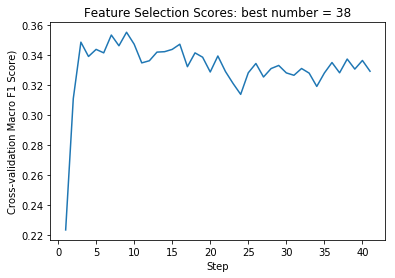

Wall time: 1min 28s


In [10]:
%%time
clf = ExtraTreesClassifier(random_state = 10, n_estimators = 100, n_jobs = -1)
selector = RFECV(clf, step=STEP, cv=kfold, scoring=f1_scorer, n_jobs=-1)

selector.fit(X_transformed, y_data)
plot_feature_selection(selector)

In [34]:
train_selected = selector.transform(X_transformed)
# Convert back to dataframe
selected_features = X_transformed.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train_selected, columns = selected_features)
print(selected_features[:10])

train_X, val_X, train_y, val_y = train_test_split(train_selected, y_data, test_size=0.25,
                                                 random_state=10)

Index(['rent_by_dep', 'meaneduc', 'escolari', 'educ_rank', 'adult_percent',
       'age', 'wall_rank', 'cooking_rank', 'wall_quality',
       'house_material_good'],
      dtype='object')


In [35]:
# Save 
train_X.to_hdf('../models/training.hdf', key='train_X')
train_y.to_hdf('../models/training.hdf', key='train_y')
val_X.to_hdf('../models/training.hdf', key='val_X')
val_y.to_hdf('../models/training.hdf', key='val_y')

# TODO - add algorithm comparison plot!

##  Get cross-validation score after feature selection and before hyperparameter tuning

In [36]:
# Pull some reasonable baseline parameters from https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough
# NOTE - he uses early-stopping rounds = 100, but I'll stick to 10 for now since I'll later optimize to 10 for speed)
params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   'num_leaves': 36, 'reg_alpha': 0.76, 
                   'reg_lambda': 0.43, 
                   'subsample_for_bin': 40000, 
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}

fit_params = {"eval_set": [(val_X, val_y)], 
              "early_stopping_rounds": EARLY_STOPPING_ROUNDS, 
              "verbose": False}

model = lgb.LGBMClassifier(**params, objective = 'multiclass', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)

In [37]:
cv_score = cross_val_score(model, train_X, train_y, cv=kfold, scoring=f1_scorer, n_jobs=-1, fit_params=fit_params)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

Cross Validation F1 Score = 0.4037 with std = 0.0365


## Hyperparameter Tuning using Hyperopt
I have found that different runs get vastly different optimal parameters (even though `random_state` was set for the train/val split. Not sure if there's a way to set seed for `hyperopt`. 

In [38]:
# Give some baseline 
params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   'num_leaves': 36, 'reg_alpha': 0.76, 
                   'reg_lambda': 0.43, 
                   'subsample_for_bin': 40000, 
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}

model = lgb.LGBMClassifier(**params, objective = 'multiclass', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)

In [39]:
def objective(space, params=params, noisy=False):
    if noisy: print(f'Training with params {space}')

    params.update(space)
    # hp.quniform sometimes returns strings (https://github.com/hyperopt/hyperopt/issues/253)
    params['num_leaves'] = int(params['num_leaves'])
    params['min_child_samples'] = int(params['min_child_samples'])
    params['max_depth'] = int(params['max_depth'])
    
    if params['num_leaves'] <3:
        import pdb; pdb.set_trace()

    model = lgb.LGBMClassifier(**params, objective = 'multiclass', n_estimators=10000, 
                               n_jobs = -1, random_state = 10)
    
    fit_params = {"eval_set": [(val_X, val_y)], 
              "early_stopping_rounds": EARLY_STOPPING_ROUNDS,
              "verbose": False} 
    
    model.fit(train_X, train_y, **fit_params)
    predictions = model.predict(val_X)
    score = f1_score(val_y, predictions, average = 'macro')
    
    if noisy: print(f'f1 score: {score}')
    
    return{'loss':1-score, 'status': STATUS_OK }

space ={'limit_max_depth': hp.choice('limit_max_depth', [True, False]),
        'max_depth': hp.quniform('max_depth', 4, 40, 1), 
        'num_leaves': hp.quniform('num_leaves', 3, 50, 1),
        'min_child_samples':hp.quniform('min_child_samples', 5, 15, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
        'subsample': hp.uniform('subsample', 0.50, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),}

seed = 42
trials = Trials()

#### Reminder 
if you do not reinstantiate `trials` you can pick up the optimization where it left off by increasing `max_evals` and re-running the below cell (though may not be replicable)

In [40]:
%%capture --no-stdout
%%time
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials,
            rstate= np.random.RandomState(seed))

best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])
best['max_depth'] = int(best['max_depth'])

Wall time: 3min 38s


In [41]:
tuned_params = params.copy()
tuned_params.update(best)
tuned_params

{'boosting_type': 'dart',
 'colsample_bytree': 0.5796397953791418,
 'learning_rate': 0.08739537002929919,
 'min_child_samples': 15,
 'num_leaves': 48,
 'reg_alpha': 0.4239159481112283,
 'reg_lambda': 0.36419362906439723,
 'subsample_for_bin': 40000,
 'subsample': 0.986210861412967,
 'class_weight': 'balanced',
 'limit_max_depth': 1,
 'max_depth': 22}

In [42]:
pickle.dump(tuned_params, open("../models/tuned_params.p", "wb"))
pickle.dump(fit_params, open("../models/fit_params.p", "wb"))

In [43]:
# Final cross-validation score
model = lgb.LGBMClassifier(**tuned_params, objective = 'multiclass', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)

cv_score = cross_val_score(model, train_X, train_y, cv=kfold, scoring=f1_scorer, n_jobs=-1, fit_params=fit_params)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

Cross Validation F1 Score = 0.4152 with std = 0.0078


# Quick question: 
Can I use "expert opinion" to choose ~30 features and see if I can beat the cross-validation score? Intuitively, I would have used more asset-based and house-quality features than demographics (e.g. the 3 most important features are age_sum, age_std, and age_min, so maybe that's overfitted)

##### NOTE - see other notebook for final model diagnostics included feature importances

### Result: 
Well, the cross-validation scores are similar, but it looks like that's just because the model more heavily weights the features originally most important (age, age_min, meaneduc) and gives very little weight to some of my manually selected features (e.g. water_rank, roof_rank). 

In [21]:
my_features = ['asset_index', 'house_utility_vulnerability', 'qmobilephone', 'tech', 'tablet_per_person_household',
               'floor_rank', 'wall_rank', 'roof_rank', 'water_rank', 'electricity_rank',
                'house_material_bad', 'house_material_good', 'toilet_rank', 'cooking_rank', 'trash_rank',
               'dependency_count', 'calc_dependency', 'child_per_bedroom', 'adult', 'adult_percent', 
               'meaneduc', 'escolari', 'educ_rank', 'rez_esc', 'escolari_sum', 'age_min', 'escolari_min', 'escolari_sum', 'age',
               'no_primary_education', 'higher_education']
               
len(my_features)    

31

In [31]:
train2_selected = X_transformed[my_features]
train2_X, val2_X, train2_y, val2_y = train_test_split(train2_selected, y_data, test_size=0.25,
                                                 random_state=10)

<Figure size 576x1080 with 0 Axes>

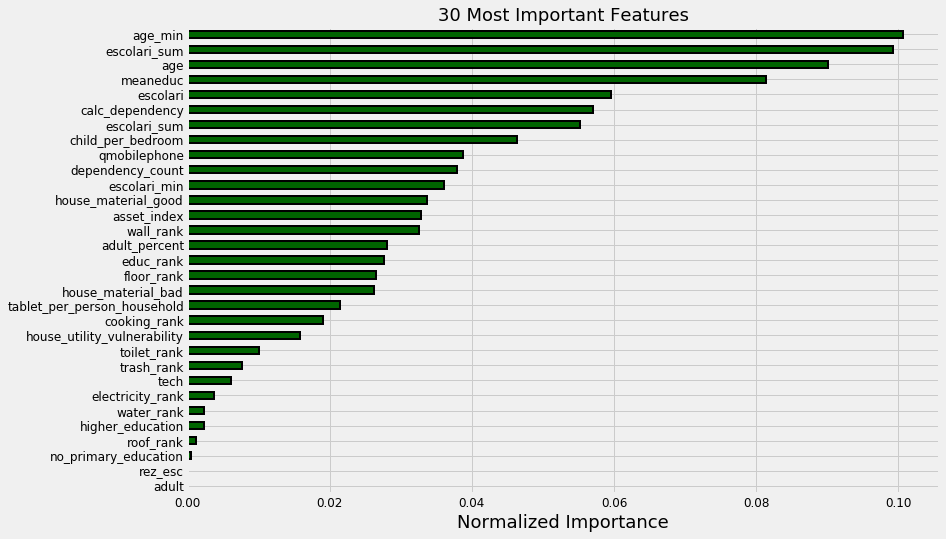

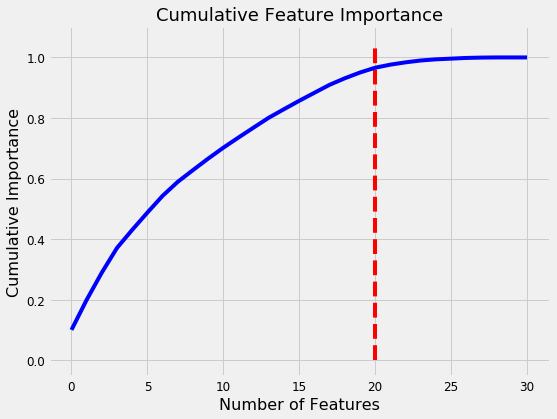

20 features required for 95% of cumulative importance.


In [32]:
fit_params = {"eval_set": [(val2_X, val2_y)], 
              "early_stopping_rounds": EARLY_STOPPING_ROUNDS, 
              "verbose": False}
model = lgb.LGBMClassifier(**tuned_params, objective = 'multiclass', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)

model.fit(train2_X, train2_y, **fit_params)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': my_features, 'importance': model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plot_feature_importances(feature_importances, n=30, threshold=0.95)

In [33]:
%%time
cv_score = cross_val_score(model, train2_X, train2_y, cv=kfold, scoring=f1_scorer, n_jobs=-1, fit_params=fit_params)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

Cross Validation F1 Score = 0.4071 with std = 0.0135
Wall time: 4.66 s
